In [1]:
# Télécharger les packages
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
products = pd.read_csv('amazon_baby.csv')

In [3]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183531 entries, 0 to 183530
Data columns (total 3 columns):
name      183213 non-null object
review    182702 non-null object
rating    183531 non-null int64
dtypes: int64(1), object(2)
memory usage: 4.2+ MB


In [4]:
# Explorer les données
products.head()

,name,review,rating
0,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion ...",3
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5


In [5]:
products['name'].head()

0                             Planetwise Flannel Wipes
1                                Planetwise Wipe Pouch
2                  Annas Dream Full Quilt with 2 Shams
3    Stop Pacifier Sucking without tears with Thumb...
4    Stop Pacifier Sucking without tears with Thumb...
Name: name, dtype: object

In [6]:
giraffe_reviews=products[products['name']=='Vulli Sophie the Giraffe Teether']

In [7]:
giraffe_reviews.shape

(785, 3)

In [8]:
giraffe_reviews.head()

,name,review,rating
34313,Vulli Sophie the Giraffe Teether,He likes chewing on all the parts especially t...,5
34314,Vulli Sophie the Giraffe Teether,My son loves this toy and fits great in the di...,5
34315,Vulli Sophie the Giraffe Teether,There really should be a large warning on the ...,1
34316,Vulli Sophie the Giraffe Teether,All the moms in my moms\' group got Sophie for...,5
34317,Vulli Sophie the Giraffe Teether,I was a little skeptical on whether Sophie was...,5


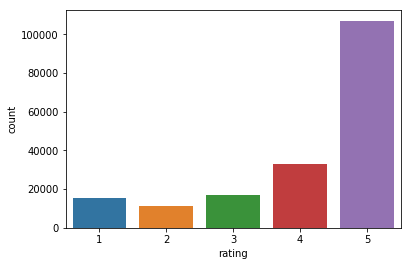

In [9]:
#Build a sentiment classifier
sns.countplot(x = 'rating' , data = products)

In [10]:
##Define what's a positive and negative sentiment
#ignore all 3* reviews
products = products[products['rating'] != 3]

In [11]:
#postitive sentiment=4* or 5*
products['sentiment']=products['rating']>=4
products['sentiment'] = products['sentiment'].apply(lambda x: 1 if x==True else 0)

# TF-IDF

In [12]:
products = products[products['review'].isna()!=True] #Supprimer les données manquantes 

In [16]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
products['stemmed'] = products['review'].map(lambda x: ' '.join([stemmer.stem(y) for y in x.split(' ')]))
products.stemmed.head()

1    it came earli and was not disappointed. i love...
2    veri soft and comfort and warmer than it looks...
3    this is a product well worth the purchase.  i ...
4    all of my kid have cri non-stop when i tri to ...
5    when the binki fairi came to our house, we did...
Name: stemmed, dtype: object

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

cvec = CountVectorizer(stop_words='english', min_df=1, max_df=.5, ngram_range=(1,2))
cvec

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.5, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [19]:
# Calculate all the n-grams found in all documents
from itertools import islice

cvec.fit(products.stemmed)
list(islice(cvec.vocabulary_.items(), 20))

[('condit pieces', 366366),
 ('darn adorable', 429005),
 ('babi neic', 127616),
 ('anyth carri', 89012),
 ('avoid bed', 118075),
 ('want toy', 1768263),
 ('shoulder pull', 1427278),
 ('thicker bottles', 1626496),
 ('torrenti downpoar', 1663849),
 ('cover nicer', 396529),
 ('walker sturdy', 1762942),
 ('head higher', 746116),
 ('replac complet', 1321713),
 ('oz jar', 1129361),
 ('lbs couldn', 885286),
 ('creat vaccin', 404850),
 ('usa price', 1726635),
 ('regular jammies', 1312298),
 ('suggest known', 1574226),
 ('shorten hid', 1426227)]

In [20]:
# Check how many total n-grams we have
len(cvec.vocabulary_)

1847324

In [19]:
# Initialize the vectorizer with new settings and check the new vocabulary length
cvec = CountVectorizer(stop_words='english', min_df=.0025, max_df=.1, ngram_range=(1,2))
cvec.fit(products.stemmed)
len(cvec.vocabulary_)

2102

In [21]:
cvec_counts = cvec.transform(products.stemmed)
print('sparse matrix shape:', cvec_counts.shape)
print('nonzero count:', cvec_counts.nnz)
print('sparsity: %.2f%%' % (100.0 * cvec_counts.nnz / (cvec_counts.shape[0] * cvec_counts.shape[1])))

sparse matrix shape: (165975, 2102)
nonzero count: 3693832
sparsity: 1.06%


In [53]:
#Let’s look at the top 10 most common terms
occ = np.asarray(cvec_counts.sum(axis=0)).ravel().tolist()
counts_df = pd.DataFrame({'term': cvec.get_feature_names(), 'occurrences': occ})
counts_df.sort_values(by='occurrences', ascending=False).head(10)

,occurrences,term
1748,24936,stroller
288,22415,car
151,21652,bag
1875,19695,tri
1820,19646,thing
480,19546,diaper
2089,19211,year
1194,19050,nice
1413,19014,purchas
2005,18911,want


In [24]:
transformer = TfidfTransformer()
transformed_weights = transformer.fit_transform(cvec_counts)
transformed_weights

<165975x2102 sparse matrix of type '<class 'numpy.float64'>'
	with 3693832 stored elements in Compressed Sparse Row format>

In [25]:
#And we can take a look at the top 10 terms by average tf-idf weight:
weights = np.asarray(transformed_weights.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': cvec.get_feature_names(), 'weight': weights})
weights_df.sort_values(by='weight', ascending=False).head(10)

,term,weight
1748,stroller,0.014913
288,car,0.014767
1194,nice,0.014593
151,bag,0.014478
1864,toy,0.014144
2089,year,0.013202
480,diaper,0.012997
1413,purchas,0.012857
761,got,0.012685
439,cute,0.012654


In [27]:
#And that about wraps it up for Tf-idf calculation. 
#As an example, you can jump straight to the end using the TfidfVectorizer class:
from sklearn.feature_extraction.text import TfidfVectorizer

tvec = TfidfVectorizer(min_df=.0025, max_df=.1, stop_words='english') #, ngram_range=ngramrange
tvec_weights = tvec.fit_transform(products.stemmed.dropna())

weights    = np.asarray(tvec_weights.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': tvec.get_feature_names(), 'weight': weights})
weights_df.sort_values(by='weight', ascending=False).head(10)

,term,weight
228,car,0.016715
915,nice,0.016288
1369,stroller,0.016249
121,bag,0.015708
1469,toy,0.015625
1619,year,0.014876
365,cute,0.014332
395,diaper,0.014191
1290,soft,0.014155
1092,purchas,0.014066


# Régression logistique 

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split

In [31]:
y = products['sentiment'] 
X = transformed_weights

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [33]:
#Let training the sentiment classifier
model = LogisticRegression()
model.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [34]:
predictions = model.predict(X_test)

In [35]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.82      0.60      0.70      6568
          1       0.93      0.98      0.95     34926

avg / total       0.91      0.92      0.91     41494



### Applying the learned model to understand sentiment for giraffe

In [63]:
gi = products[products['name']=='Vulli Sophie the Giraffe Teether']
gi_counts = cvec.transform(gi.stemmed)
gi_counts.shape

(717, 2102)

In [64]:
transformer = TfidfTransformer()
X_GIR = transformer.fit_transform(gi_counts)

In [94]:
model.predict(X_GIR)[1:30]

array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1], dtype=int64)

In [95]:
np.array(gi['sentiment'][1:30])

array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1], dtype=int64)

In [107]:
model.predict_proba(X_GIR)[1:30]

array([[  4.85397224e-04,   9.99514603e-01],
       [  6.05545077e-01,   3.94454923e-01],
       [  1.31498088e-02,   9.86850191e-01],
       [  5.94265647e-02,   9.40573435e-01],
       [  1.77913269e-02,   9.82208673e-01],
       [  1.60179176e-01,   8.39820824e-01],
       [  6.16498452e-02,   9.38350155e-01],
       [  9.97224131e-02,   9.00277587e-01],
       [  2.26451538e-02,   9.77354846e-01],
       [  2.54179866e-02,   9.74582013e-01],
       [  4.98072131e-01,   5.01927869e-01],
       [  3.38061434e-01,   6.61938566e-01],
       [  1.42991744e-02,   9.85700826e-01],
       [  6.03177688e-02,   9.39682231e-01],
       [  6.91226109e-03,   9.93087739e-01],
       [  5.11734637e-03,   9.94882654e-01],
       [  2.68796339e-02,   9.73120366e-01],
       [  2.17662612e-02,   9.78233739e-01],
       [  1.10088088e-01,   8.89911912e-01],
       [  6.71908797e-02,   9.32809120e-01],
       [  2.94194213e-01,   7.05805787e-01],
       [  8.85470128e-03,   9.91145299e-01],
       [  

In [108]:
X_GIR[1:30]

<29x2102 sparse matrix of type '<class 'numpy.float64'>'
	with 531 stored elements in Compressed Sparse Row format>

# Model Two

In [109]:
selected_words = ['awesome', 'great', 'fantastic', 'amazing', 'love', 'horrible', 'bad', 
                  'terrible', 'awful', 'wow', 'hate']

In [110]:
products.head()

,name,review,rating,sentiment,stemmed
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5,1,it came earli and was not disappointed. i love...
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5,1,veri soft and comfort and warmer than it looks...
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5,1,this is a product well worth the purchase. i ...
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1,all of my kid have cri non-stop when i tri to ...
5,Stop Pacifier Sucking without tears with Thumb...,"When the Binky Fairy came to our house, we did...",5,1,"when the binki fairi came to our house, we did..."


In [175]:
selected_words = ['awesome', 'great', 'fantastic', 'amazing', 'love', 'horrible', 'bad', 
                  'terrible', 'awful', 'wow', 'hate']

In [174]:
products['awesome']   = products['stemmed'].apply(lambda x : 1 if 'awesome' in x else 0)
products['great']     = products['stemmed'].apply(lambda x : 1 if 'great' in x else 0)
products['fantastic'] = products['stemmed'].apply(lambda x : 1 if 'fantastic' in x else 0)
products['amazing']   = products['stemmed'].apply(lambda x : 1 if 'amazing' in x else 0)
products['love']      = products['stemmed'].apply(lambda x : 1 if 'love' in x else 0)
products['horrible']  = products['stemmed'].apply(lambda x : 1 if 'horrible' in x else 0)
products['bad']       = products['stemmed'].apply(lambda x : 1 if 'bad' in x else 0)
products['terrible']  = products['stemmed'].apply(lambda x : 1 if 'terrible' in x else 0)
products['awful']     = products['stemmed'].apply(lambda x : 1 if 'awful' in x else 0)
products['wow']       = products['stemmed'].apply(lambda x : 1 if 'wow' in x else 0)
products['hate']      = products['stemmed'].apply(lambda x : 1 if 'hate' in x else 0)

In [176]:
X = np.array(products[selected_words])
y = products['sentiment']

In [188]:
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=34)

In [189]:
model2 = LogisticRegression()
model2.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [190]:
predictions2 = model2.predict(X_test)

In [191]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions2))

             precision    recall  f1-score   support

          0       0.78      0.03      0.06      6619
          1       0.84      1.00      0.91     34875

avg / total       0.83      0.84      0.78     41494

